# California Wildfires
### Donated by: Casey Graff (graffc@uci.edu)

* ### Task: 2D Classificaiton (similiar to image segmentation)
* ### # of Instances: 10k train / 5k test (more upon request)
* ### Data
    * #### Input: 3D Image (# Channels, Height, Width)
    * #### Output: 2D Classification Probabilites (Height, Width)

## Description

This challenge dataset focuses on the spatiotemporal prediction problem of forecasting how wildfires will spread in 12 or 24 hour periods. 

**Active fires** are observed using the VIIRS (Visible Infrared Imaging Radiometer Suite) mounted on the Suomi National Polar-orbiting Partnership (NPP) satellite. 

These fires are influenced by **land cover**, **topography**, and **weather** (among others not captured in this dataset). 

All data sources have been rescaled to **375m / pixel**. Each image contains 30 x 30 pixels  for an effective real **area of 11.25km**.

## Data
### I. VIIRS Fire Detections
* 5 layers / time steps (T = 0, -12, -24, -36, -48 hours)
* 2 targets (T = +12 hours, +24 hours)

### II. Land Cover (LANDFIRE)
* 17 layers (3 topographic, 10 vegetation, 4 fuel/canopy)

### III. Meteorology (Rapid Refresh)
* 2 time steps (T = 0, +12 hours) x 5 variables (temperature, humidity, etc.)

### Imports + Setup

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
FIG_REG_WIDTH = 7
FIG_REG_ASPECT_RATIO = 1.75

def set_fig_settings(fig_size=(32,10), font_size=16, font_scale=1.6):       
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams["legend.framealpha"] = 0

    font = {'weight' : 'normal', 'size'   : font_size}

    plt.rc('font', **font)

### Data Loading

In [5]:
DATASET_PATH = 'uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_10k_train.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [6]:
print(train_data.keys())

dict_keys(['datetime', 'land_cover', 'latitude', 'longitude', 'meteorology', 'observed', 'target'])


In [7]:
large_fire_inds = np.where(
    (np.sum(train_data['observed'][:,0],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,1],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,2],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,3],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,4],axis=(1,2)) > 50) & 
    (np.sum(train_data['target'][:,0],axis=(1,2)) > 50) 
)[0]

In [8]:
TRAINING_POINT = large_fire_inds[0]

## I. VIIRS Detections (Observed + Target)

### Source: https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/viirs-i-band-active-fire-data

### Resolution: ~375m -> 375m

In [9]:
print('Shape:', train_data['observed'].shape, '= (# of Instances, # of Timesteps/Lags, Width, Height)')

Shape: (10000, 5, 30, 30) = (# of Instances, # of Timesteps/Lags, Width, Height)


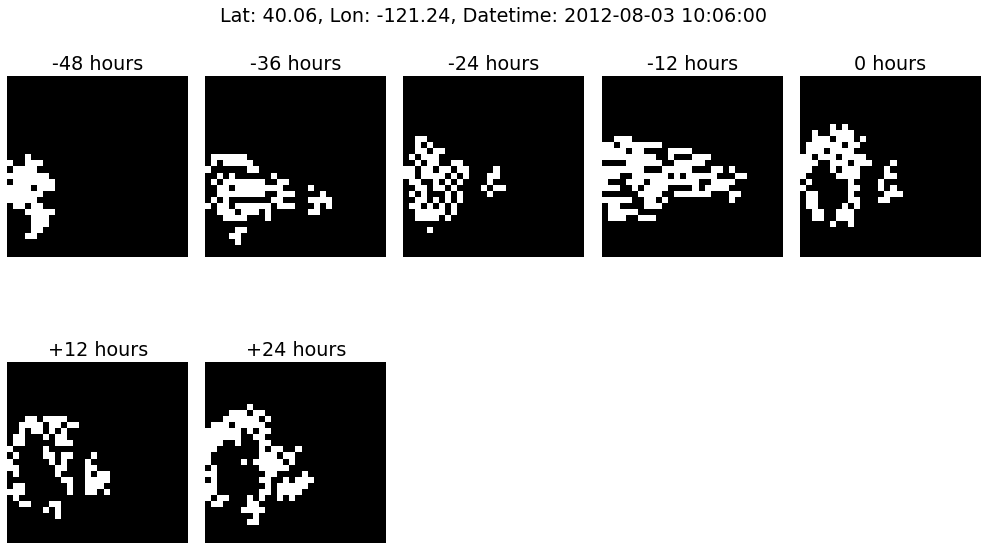

In [12]:
set_fig_settings((FIG_REG_WIDTH*2,FIG_REG_WIDTH*1.25))
fig = plt.figure()

lat = train_data['latitude'][TRAINING_POINT]
lon = train_data['longitude'][TRAINING_POINT]
datetime = pd.to_datetime(train_data['datetime'][TRAINING_POINT])

fig.suptitle(f'Lat: {lat:.2f}, Lon: {lon:.2f}, Datetime: {datetime}')

# Plot X detections
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title(f'{-12 * (4-i)} hours')
    plt.imshow(train_data['observed'][TRAINING_POINT][4-i], cmap='gray')
    plt.axis('off')

# Plt Y detections
for i in range(2):
    plt.subplot(2,5,i+5+1)
    plt.title(f'+{12 * (i+1)} hours')
    plt.imshow(train_data['target'][TRAINING_POINT][i], cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

## II. Land Cover

### Source: https://www.landfire.gov/
### Resolution: 30m -> 375m

#### Layers
* 0: Aspect 
* 1: Canopy Bult Density
* 2: Canopy Base Height
* 3: Canopy Cover
* 4: Canopy Height
* 5: Elevelation
* 6 to 15: Vegetation (Fractional Veg Class per layer)
* 16: Slope

#### Vegetation Layers
* 6: No Data
* 7: Sparse
* 8: Tree
* 9: Shrub
* 10: Herb
* 11: Water
* 12: Barren
* 13: Developed
* 14: Snow-Ice
* 15: Agriculture

In [25]:
LAND_COVER_LAYER_NAME_TO_IND = {'ASP': 0, 'CBD': 1, 'CBH': 2, 'CC': 3, 'CH': 4, 'DEM': 5, 'EVT': 6, 'SLP': 16}
VEGETATION_NAME_TO_IND = {'Nodata': 0, 'Sparse': 1, 'Tree': 2, 'Shrub': 3, 'Herb': 4, 'Water': 5, 'Barren': 6, 'Developed': 7, 'Snow-Ice': 8, 'Agriculture': 9}

TOPO_NAMES = ['ASP', 'SLP', 'DEM']
VEG_NAME = 'EVT'
FUEL_NAMES = ['CBD', 'CBH', 'CC', 'CH']

In [14]:
print('Shape:', train_data['land_cover'].shape, '= (# of Instances, # of Layers, Width, Height)')

Shape: (10000, 17, 30, 30) = (# of Instances, # of Layers, Width, Height)


[[190.2336 202.5504 185.1504 148.4176  49.9552  62.3392 190.2736 198.3888
  144.5536 104.6976 126.6048 198.1792 192.952  115.4128 139.072  177.7024
  247.936  125.2704 211.1296 163.5392  86.7488 135.3952 196.448  181.2832
  205.896  189.24   201.3856 224.8256 192.6832 245.288 ]
 [137.5904 185.088  190.1904 208.4784 175.808   95.1104  95.2784 199.9824
  172.7936 157.5328  94.976  186.096  179.6592 159.7584 154.7072 215.2384
  235.4656 134.2464 246.1984 120.5664 116.9568 140.0096 197.552  268.9216
  320.1008 137.7168 217.5904  73.4784 192.7696 267.0768]
 [ 34.832   27.0944  85.3968 174.712  205.3296 151.384  104.824  100.776
  177.2672 204.192  107.7504 129.2512 165.48   195.4576 137.6896 238.1888
  184.584  166.664  246.9408  84.9728  60.2352 130.8656 261.8208 229.4176
  294.744  141.416  132.6272 111.6608 152.7024 215.72  ]
 [103.2064  51.9552  60.856   81.9152 143.8896 170.6352 125.9344  64.9904
   70.3296 133.1264 180.3808 116.992  132.984  190.7504 171.0528 219.3408
  160.984  232.7

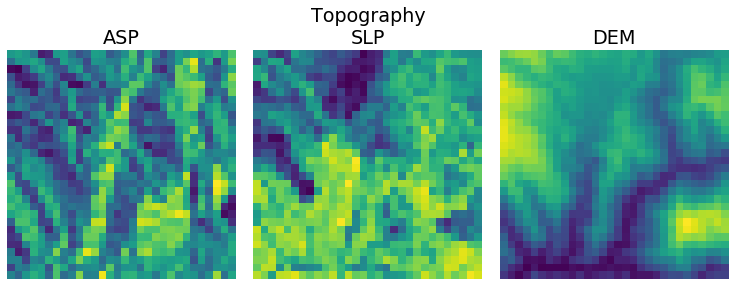

In [26]:
set_fig_settings((FIG_REG_WIDTH*1.5,FIG_REG_WIDTH*.65))
fig = plt.figure()

fig.suptitle('Topography')
for i, name in enumerate(TOPO_NAMES):
    plt.subplot(1,len(TOPO_NAMES),i+1)
    print(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    plt.title(name)
    plt.axis('off')
    
plt.tight_layout()

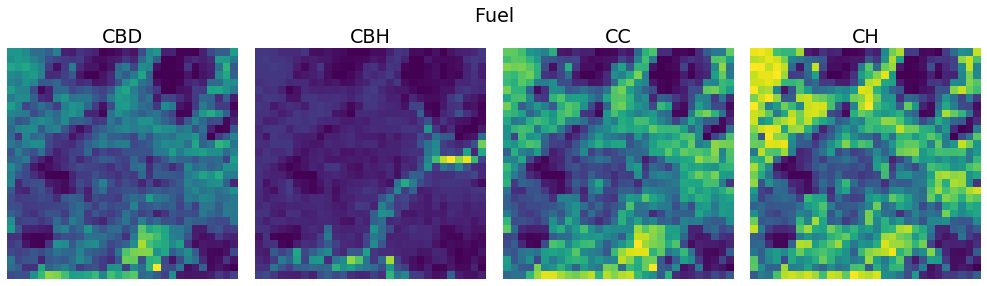

In [17]:
set_fig_settings((FIG_REG_WIDTH*2,FIG_REG_WIDTH*.65))
fig = plt.figure()

fig.suptitle('Fuel')
for i, name in enumerate(FUEL_NAMES):
    plt.subplot(1,len(FUEL_NAMES),i+1)
    plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[name]])
    plt.title(name)
    plt.axis('off')

plt.tight_layout()

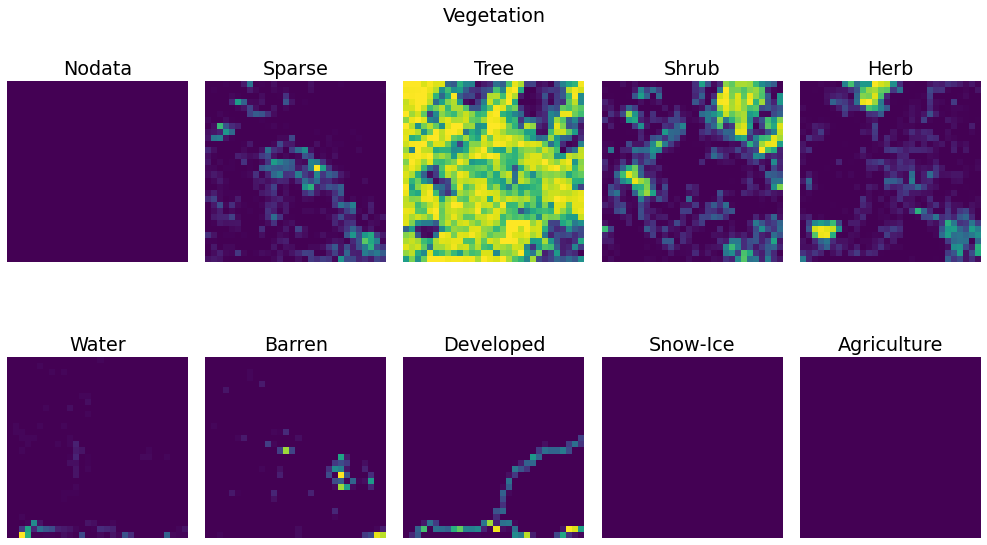

In [15]:
set_fig_settings((FIG_REG_WIDTH*2,FIG_REG_WIDTH*1.25))
fig = plt.figure()

fig.suptitle('Vegetation')
for i, (name, ind) in enumerate(VEGETATION_NAME_TO_IND.items()):
    plt.subplot(2,len(VEGETATION_NAME_TO_IND)//2,i+1)
    plt.imshow(train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND[VEG_NAME] + ind])
    plt.title(name)
    plt.axis('off')

plt.tight_layout()

## III. Weather

### Source: https://rapidrefresh.noaa.gov/
###  Resolution 13km -> 375m

#### Timesteps
* 0: T = -48 hours 
* 1: T = -36 hours
* 2: T = -24 hours
* 3: T = -12 hours
* 4: T =   0 hours (closest measurement to observed VIIRS detections)
* 5: T =  12 hours (closest measurement to taget VIIRS detections)

#### Variables
* 0: Temperature @ 2m (Kelvin)
* 1: Relative Humidity @ 2m (%)
* 2: U Wind Component @ 10m (m s**-1)
* 3: V Wind Component @ 10m (m s**-1)
* 4: Precipitation Rate (kg m**-2 s**-1)


In [19]:
METEOROLOGY_NAME_TO_IND = {'Temp': 0, 'Rel. Humid.': 1, 'U Wind Comp.': 2, 'V Wind Comp.': 3, 'Precip. Rate': 4}

In [20]:
print('Shape:', train_data['meteorology'].shape, '= (# of Instances, Timesteps, # of Variables, Width, Height)')

Shape: (10000, 2, 5, 30, 30) = (# of Instances, Timesteps, # of Variables, Width, Height)


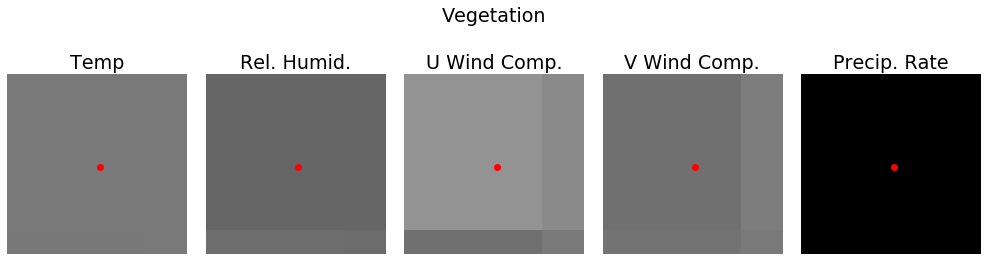

In [22]:
set_fig_settings((FIG_REG_WIDTH*2,FIG_REG_WIDTH*.65))
fig = plt.figure()

fig.suptitle('Vegetation')
for i, (name, ind) in enumerate(METEOROLOGY_NAME_TO_IND.items()):
    plt.subplot(1,len(METEOROLOGY_NAME_TO_IND),i+1)
    vmin = np.nanmin(train_data['meteorology'][:,0,ind])
    vmax = np.nanmax(train_data['meteorology'][:,0,ind])
    plt.imshow(train_data['meteorology'][TRAINING_POINT][0][ind], vmin=vmin, vmax=vmax, cmap='gray')
    plt.scatter([15], [15], c='red')
    plt.title(name)
    plt.axis('off')

plt.tight_layout()

IndexError: index 2 is out of bounds for axis 0 with size 2

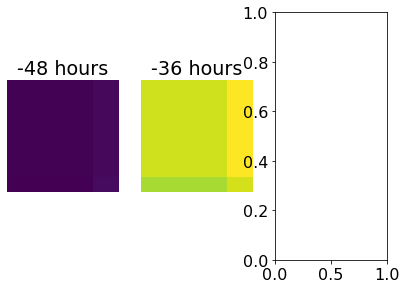

In [24]:
vmin = np.min(train_data['meteorology'][TRAINING_POINT,:,METEOROLOGY_NAME_TO_IND['Temp']])
vmax = np.max(train_data['meteorology'][TRAINING_POINT,:,METEOROLOGY_NAME_TO_IND['Temp']])

for i in range(6):    
    plt.subplot(1,6,i+1)
    plt.imshow(train_data['meteorology'][TRAINING_POINT][i][METEOROLOGY_NAME_TO_IND['Temp']], vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title(f'{(i - 4) * 12} hours')

Note how temperature alternates between low and high every 12 hours above. This is due to daytime/nighttime temperatures.

## Task / Prediction

In [26]:
import scipy.ndimage

In [51]:
def persistence_model(x):
    return scipy.ndimage.gaussian_filter(x, 1.7, output=np.float32)

def compute_mse(y, y_hat):
    return np.mean((y-y_hat)**2)

In [47]:
x = train_data['observed'][TRAINING_POINT,0]
y = train_data['target'][TRAINING_POINT,0]
y_pred = persistence_model(x)

(-0.5, 29.5, 29.5, -0.5)

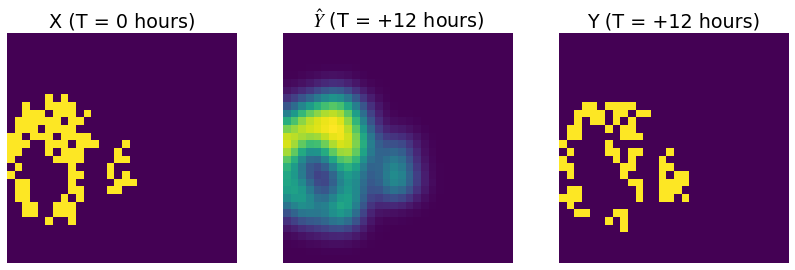

In [46]:
plt.subplot(1,3,1)
plt.imshow(x)
plt.title('X (T = 0 hours)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(y_pred)
plt.title('$\hat{Y}$ (T = +12 hours)')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(y)
plt.title('Y (T = +12 hours)')
plt.axis('off')

In [49]:
y_hats = [persistence_model(train_data['observed'][i,0]) for i in range(len(train_data['observed']))]

In [55]:
mse_12hour = compute_mse(train_data['target'][:,0], y_hats)
mse_24hour = compute_mse(train_data['target'][:,1], y_hats)

print(f'MSE: 12 Hour Target = {mse_12hour:.4f}, 24 Hour Target = {mse_24hour:.4f}')

MSE: 12 Hour Target = 0.0498, 24 Hour Target = 0.0543
